In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import text, sequence
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow import keras
from normalizer import Normalizer
from results import ModelEvaluation

tf.device = tf.device("gpu")

In [2]:
data = pd.read_csv("../dataset/TwitterDataset.txt", sep="\t")

    Let's describe the data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39776 entries, 0 to 39775
Data columns (total 3 columns):
 #   Column                                                                                                                          Non-Null Count  Dtype 
---  ------                                                                                                                          --------------  ----- 
 0   TrainSen                                                                                                                        39776 non-null  object
 1   0                                                                                                                               39776 non-null  int64 
 2   @0430yes i hope youre lurking rn. i want to listen to hallucination & wanna love you again live someday, pretty please?! 😭 😭 😭  39776 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.4+ KB


    There are no column names let's provide column names.

In [4]:
data.columns = ["sample_type", "label", "text"] #changes column names of the dataset.
data = data.drop(columns=["sample_type"]) #drop the redudant column.
data = data.sample(frac=1, random_state=42).reset_index(drop=True) #shuffle the dataset.

In [5]:
data.head(10)

,label,text
0,1,About to make up an entire essay good think I'...
1,0,@bonnielazzara @gamegirl404 @claudia_cpucci @H...
2,1,American Literature has been an interesting co...
3,1,@rachelkcollier sound like backing vocalists #...
4,1,I said I was gonna wash my face before I went ...
5,1,I used to think i was good at multi-tasking. T...
6,1,It's okay to burn a flag with your 1st Amendme...
7,0,🌸💐🌸💐🌸 HAPPY FRIDAY Blessings ~Love ~Light Wish...
8,1,last picture with my beautifull sister 3 R. I....
9,1,Side joy of business travel : spur of the mome...


    Get Embedding vectors representation of the text:

In [6]:
normarlizer = Normalizer()
matrix = normarlizer.vectorize(pd.DataFrame({"text": data["text"]}))

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.


    Let's split this up for tesing:

In [7]:
y= data["label"]
X = matrix
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    Build the model:

In [11]:
mlp = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

mlp.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    Fit this model:

In [12]:
history = mlp.fit(X_train.toarray(), y_train, epochs=7, batch_size=32, validation_data=(X_test.toarray(), y_test))


Epoch 1/7
995/995 [==============================] - 16s 16ms/step - loss: 0.5127 - accuracy: 0.7509 - val_loss: 0.4661 - val_accuracy: 0.7795
Epoch 2/7
995/995 [==============================] - 13s 13ms/step - loss: 0.3949 - accuracy: 0.8288 - val_loss: 0.4526 - val_accuracy: 0.7947
Epoch 3/7
995/995 [==============================] - 13s 13ms/step - loss: 0.3564 - accuracy: 0.8495 - val_loss: 0.4524 - val_accuracy: 0.7991
Epoch 4/7
995/995 [==============================] - 12s 12ms/step - loss: 0.3292 - accuracy: 0.8631 - val_loss: 0.4616 - val_accuracy: 0.7965
Epoch 5/7
995/995 [==============================] - 12s 12ms/step - loss: 0.3073 - accuracy: 0.8761 - val_loss: 0.4716 - val_accuracy: 0.7944
Epoch 6/7
995/995 [==============================] - 12s 12ms/step - loss: 0.2874 - accuracy: 0.8874 - val_loss: 0.4824 - val_accuracy: 0.7991
Epoch 7/7
995/995 [==============================] - 12s 12ms/step - loss: 0.2685 - accuracy: 0.8963 - val_loss: 0.4722 - val_accuracy: 0.7968

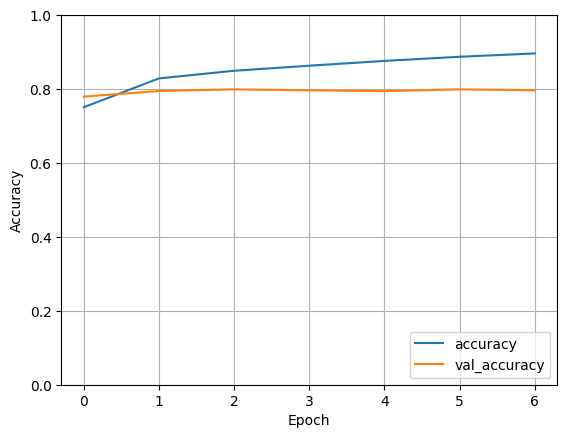

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

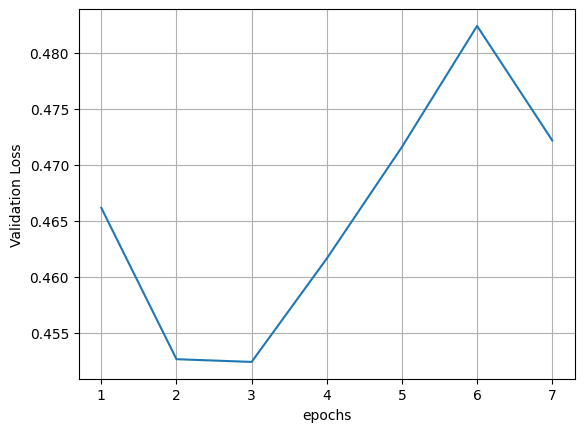

In [15]:
losses = history.history["val_loss"]
plt.plot(range(1,8), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

In [18]:
y_pred = mlp.predict(X_test.toarray())
results = ModelEvaluation()
y_pred_class = (y_pred >= 0.5).astype(int)

249/249 [==============================] - 1s 2ms/step


In [20]:
results.classification_report(y_test, y_pred_class)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4279
           1       0.79      0.77      0.78      3677

    accuracy                           0.80      7956
   macro avg       0.80      0.79      0.80      7956
weighted avg       0.80      0.80      0.80      7956



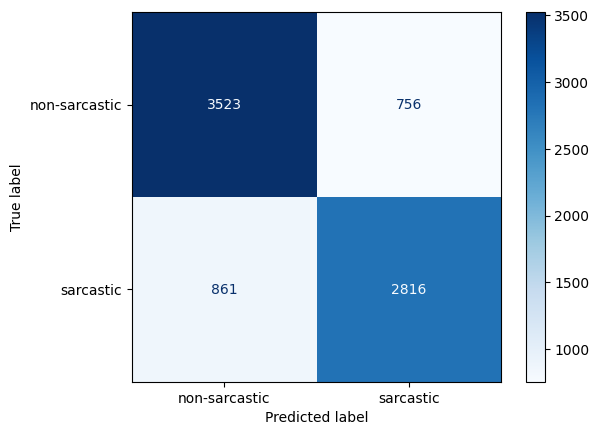

In [22]:
results.get_cm(y_true=y_test, y_pred=y_pred_class)

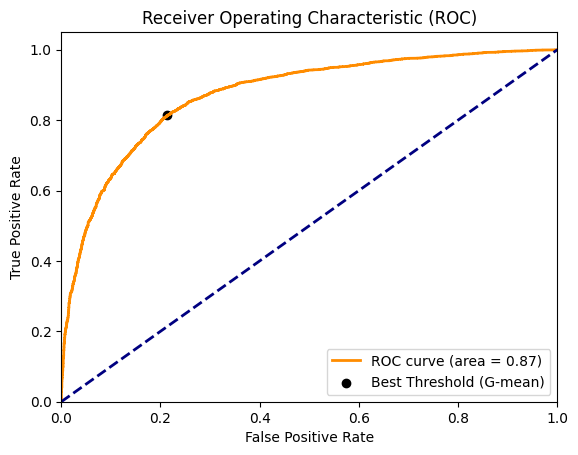

Best Threshold=0.4005


In [23]:

threshold = results.get_roc(y_true=y_test, y_scores=y_pred)

In [24]:
y_pred_class = (y_pred >= threshold).astype(int)

In [25]:
results.classification_report(y_test, y_pred_class)

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4279
           1       0.77      0.81      0.79      3677

    accuracy                           0.80      7956
   macro avg       0.80      0.80      0.80      7956
weighted avg       0.80      0.80      0.80      7956



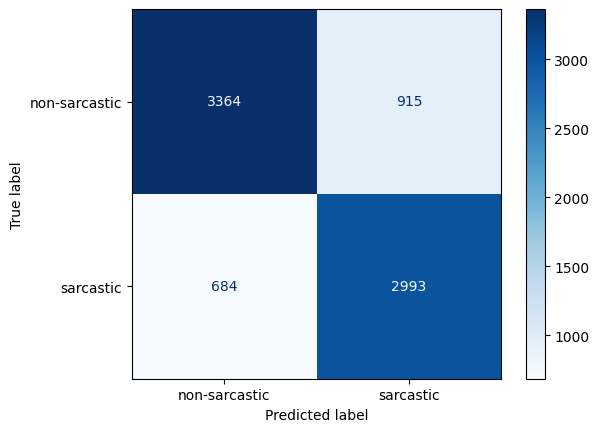

In [26]:
results.get_cm(y_true=y_test, y_pred=y_pred_class)

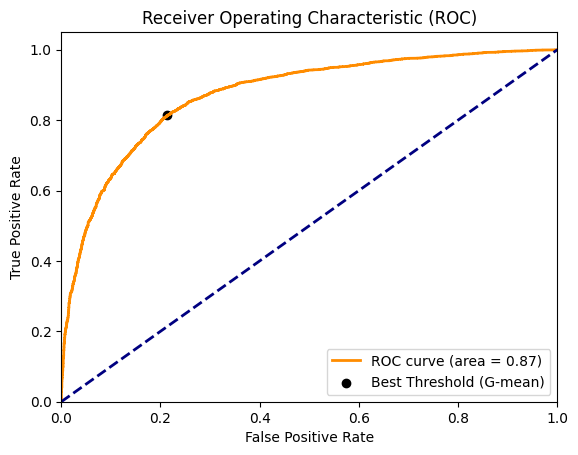

Best Threshold=0.4005


In [27]:

threshold = results.get_roc(y_true=y_test, y_scores=y_pred)

In [29]:
import joblib

joblib.dump(mlp, "../TwitterDataModels/TrainedModels/MultilayerPerceptron.joblib")

['../TwitterDataModels/TrainedModels/MultilayerPerceptron.joblib']